In [1]:
#reference : 
# 1. https://github.com/Shubha23/Text-processing-NLP/blob/master/NLP%20-%20Text%20processing%20pipeline.ipynb
# 2. https://www.kaggle.com/databeru/spam-classifier-model-comparison-accuracy-97
# 3. https://www.kaggle.com/anirudhchandnani/ann-vs-lstm-vs-bi-lstm-on-nlp

#Data manipulation 
import re
import string
import pandas as pd
import numpy as np

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud 
from wordcloud import WordCloud, ImageColorGenerator

#metrics
from sklearn.metrics import f1_score , recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, classification_report

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

#Classifiers 
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC

# Time and counters
from time import perf_counter

#grid search of params
from sklearn.model_selection import GridSearchCV


import warnings
warnings.filterwarnings('ignore')

# NLP lib
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from nltk import flatten , PorterStemmer, WordNetLemmatizer, FreqDist
from collections import Counter

from nltk.corpus import stopwords
stopwords = stopwords.words('english')

#Mark Down print
from IPython.display import Markdown, display
def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))
# To save the models
import pickle

[nltk_data] Downloading package punkt to /home/shahan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/shahan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/shahan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# read dataset as pandas dataframe
data=pd.read_csv('Datasets/spam_dataset_1/emails.csv')

# display top 5 entries of dataset
data=data.iloc[:,0:2]
#data.drop(data.columns.difference(['text','spam']), 1, inplace=True)
data.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [3]:
#remove duplicated data
print(f"duplicated entries {data.duplicated().sum()}")
data = data.drop_duplicates()
print(f"duplicated entries {data.duplicated().sum()}")

duplicated entries 33
duplicated entries 0


In [4]:
#remove Null values
print("Number of null features in the dataset :")
print(f"{data.isnull().sum()}")

print()
data.dropna(subset=["spam"], inplace=True)

print("Number of null features in the dataset :")
print(f"{data.isnull().sum()}")

Number of null features in the dataset :
text    0
spam    2
dtype: int64

Number of null features in the dataset :
text    0
spam    0
dtype: int64


In [5]:
print(f"shape of the dataset : {data.shape}, Number of rows and columns : {data.shape[0]} , {data.shape[1]}")

shape of the dataset : (5696, 2), Number of rows and columns : 5696 , 2


In [6]:
# Descriptive statistics

# to find count of words in each instance, tokenize instances of the dataset
sentence_tokenized = data['text'].str.split(' ')

# calculate and display the average length of instances

print(f"Average length of sentence {sum(len(word) for word in sentence_tokenized) / len(sentence_tokenized)}")
# calculate and display the max length of instances

print(f"Max length of sentence {sentence_tokenized.str.len().max()}")
print()

# display the statistics of all instances word count including: max, min average etc
print(f"Statistics of length of sentence \n{sentence_tokenized.str.len().describe()}")

Average length of sentence 354.9959620786517
Max length of sentence 6623

Statistics of length of sentence 
count    5696.000000
mean      354.995962
std       423.475097
min         3.000000
25%       112.000000
50%       232.000000
75%       438.000000
max      6623.000000
Name: text, dtype: float64


# **Data / Text pre-processing**
---

##    1. *Remove punctuations* 
##    2. *Convert text to tokens*
##    3.  *Remove tokens of length less than or equal to 3*
##    4.  *Remove stopwords using NLTK corpus stopwords list to match*
##    5.  *Apply stemming*
##    6.  *Apply lemmatization*
##    7.  *Convert words to feature vectors*

In [7]:
# Convert Spam (Label) numerics to float64
# Pre-processing of data['spam']

data["spam"] = pd.to_numeric(data["spam"], errors='coerce')
def data_head(X,label):
    Data_X = X.loc[X["spam"] != label]
    print(Data_X.head())

data_head(data, 0)

                                                text  spam
0  Subject: naturally irresistible your corporate...   1.0
1  Subject: the stock trading gunslinger  fanny i...   1.0
2  Subject: unbelievable new homes made easy  im ...   1.0
3  Subject: 4 color printing special  request add...   1.0
4  Subject: do not have money , get software cds ...   1.0


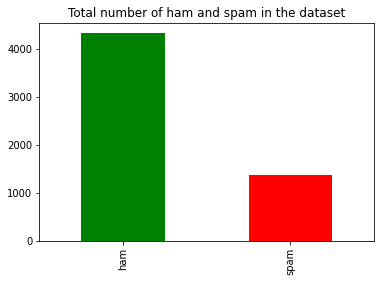

In [8]:
# Add new column named "label" where if data["spam"] is 1 then label is spam , else , ham
data['label'] = data['spam'].apply(lambda x: 'spam' if x == 1 else 'ham')

data['label'].value_counts().plot.bar(color = ["g","r"])
plt.title('Total number of ham and spam in the dataset')
plt.savefig("Visuals/ham_vs_spam.jpeg" , bbox_inches='tight')
plt.show()

In [9]:
# preprocessing of data["text"]
# Step 1: remove puntuation

def remove_puntuation(text):
    return ("".join([ch for ch in text if ch not in string.punctuation]))

data["puntuation_removed"] = data["text"].apply(lambda x: remove_puntuation(x))
data.head()

,text,spam,label,puntuation_removed
0,Subject: naturally irresistible your corporate...,1.0,spam,Subject naturally irresistible your corporate ...
1,Subject: the stock trading gunslinger fanny i...,1.0,spam,Subject the stock trading gunslinger fanny is...
2,Subject: unbelievable new homes made easy im ...,1.0,spam,Subject unbelievable new homes made easy im w...
3,Subject: 4 color printing special request add...,1.0,spam,Subject 4 color printing special request addi...
4,"Subject: do not have money , get software cds ...",1.0,spam,Subject do not have money get software cds fr...


In [10]:
# Step 2: convert all text to lower and tokenize

def text_lower_tokenized(text):
    txt = word_tokenize(text)
    txt =[w.lower() for w in txt]

#     txt = str.split(txt)
    return txt

data["tokenized_lower"] = data["puntuation_removed"].apply(lambda x: text_lower_tokenized(x))
data.head()


,text,spam,label,puntuation_removed,tokenized_lower
0,Subject: naturally irresistible your corporate...,1.0,spam,Subject naturally irresistible your corporate ...,"[subject, naturally, irresistible, your, corpo..."
1,Subject: the stock trading gunslinger fanny i...,1.0,spam,Subject the stock trading gunslinger fanny is...,"[subject, the, stock, trading, gunslinger, fan..."
2,Subject: unbelievable new homes made easy im ...,1.0,spam,Subject unbelievable new homes made easy im w...,"[subject, unbelievable, new, homes, made, easy..."
3,Subject: 4 color printing special request add...,1.0,spam,Subject 4 color printing special request addi...,"[subject, 4, color, printing, special, request..."
4,"Subject: do not have money , get software cds ...",1.0,spam,Subject do not have money get software cds fr...,"[subject, do, not, have, money, get, software,..."


In [11]:
# Step 3: convert all text to lower and tokenize
# Remove tokens of length less than 3

def remove_small_words(text):
    return [x for x in text if len(x) > 3 ]

data["large_tokens"] = data["tokenized_lower"].apply(lambda x: remove_small_words(x))
data.head()

,text,spam,label,puntuation_removed,tokenized_lower,large_tokens
0,Subject: naturally irresistible your corporate...,1.0,spam,Subject naturally irresistible your corporate ...,"[subject, naturally, irresistible, your, corpo...","[subject, naturally, irresistible, your, corpo..."
1,Subject: the stock trading gunslinger fanny i...,1.0,spam,Subject the stock trading gunslinger fanny is...,"[subject, the, stock, trading, gunslinger, fan...","[subject, stock, trading, gunslinger, fanny, m..."
2,Subject: unbelievable new homes made easy im ...,1.0,spam,Subject unbelievable new homes made easy im w...,"[subject, unbelievable, new, homes, made, easy...","[subject, unbelievable, homes, made, easy, wan..."
3,Subject: 4 color printing special request add...,1.0,spam,Subject 4 color printing special request addi...,"[subject, 4, color, printing, special, request...","[subject, color, printing, special, request, a..."
4,"Subject: do not have money , get software cds ...",1.0,spam,Subject do not have money get software cds fr...,"[subject, do, not, have, money, get, software,...","[subject, have, money, software, from, here, s..."


In [12]:
# Step 4: Remove Stop / uninteresting words
# nltk stopwords corpus or userdefined

user_defined = ["subject"]

def remove_userdefined_words(text):
    return [w for w in text if w not in user_defined]

def remove_stopwords(text):
    return [w for w in text if w not in stopwords]

data["without_stopwords"] = data["large_tokens"].apply(lambda x: remove_stopwords(x))
data["without_stopwords"] = data["without_stopwords"].apply(lambda x: remove_userdefined_words(x))
data.head()

,text,spam,label,puntuation_removed,tokenized_lower,large_tokens,without_stopwords
0,Subject: naturally irresistible your corporate...,1.0,spam,Subject naturally irresistible your corporate ...,"[subject, naturally, irresistible, your, corpo...","[subject, naturally, irresistible, your, corpo...","[naturally, irresistible, corporate, identity,..."
1,Subject: the stock trading gunslinger fanny i...,1.0,spam,Subject the stock trading gunslinger fanny is...,"[subject, the, stock, trading, gunslinger, fan...","[subject, stock, trading, gunslinger, fanny, m...","[stock, trading, gunslinger, fanny, merrill, m..."
2,Subject: unbelievable new homes made easy im ...,1.0,spam,Subject unbelievable new homes made easy im w...,"[subject, unbelievable, new, homes, made, easy...","[subject, unbelievable, homes, made, easy, wan...","[unbelievable, homes, made, easy, wanting, sho..."
3,Subject: 4 color printing special request add...,1.0,spam,Subject 4 color printing special request addi...,"[subject, 4, color, printing, special, request...","[subject, color, printing, special, request, a...","[color, printing, special, request, additional..."
4,"Subject: do not have money , get software cds ...",1.0,spam,Subject do not have money get software cds fr...,"[subject, do, not, have, money, get, software,...","[subject, have, money, software, from, here, s...","[money, software, software, compatibility, gre..."


In [13]:
# Step 5: Stemming
"""
Apply stemming to convert tokens to their root form. 
This is a rule-based process of word form conversion where word-suffixes are truncated irrespective of 
whether the root word is an actual word in the language dictionary.
"""

def stemming(text):
    ps = PorterStemmer()
    return [ps.stem(word) for word in text]

data["Stemmed"] = data["without_stopwords"].apply(lambda x: stemming(x))
data.head()

,text,spam,label,puntuation_removed,tokenized_lower,large_tokens,without_stopwords,Stemmed
0,Subject: naturally irresistible your corporate...,1.0,spam,Subject naturally irresistible your corporate ...,"[subject, naturally, irresistible, your, corpo...","[subject, naturally, irresistible, your, corpo...","[naturally, irresistible, corporate, identity,...","[natur, irresist, corpor, ident, realli, hard,..."
1,Subject: the stock trading gunslinger fanny i...,1.0,spam,Subject the stock trading gunslinger fanny is...,"[subject, the, stock, trading, gunslinger, fan...","[subject, stock, trading, gunslinger, fanny, m...","[stock, trading, gunslinger, fanny, merrill, m...","[stock, trade, gunsling, fanni, merril, muzo, ..."
2,Subject: unbelievable new homes made easy im ...,1.0,spam,Subject unbelievable new homes made easy im w...,"[subject, unbelievable, new, homes, made, easy...","[subject, unbelievable, homes, made, easy, wan...","[unbelievable, homes, made, easy, wanting, sho...","[unbeliev, home, made, easi, want, show, homeo..."
3,Subject: 4 color printing special request add...,1.0,spam,Subject 4 color printing special request addi...,"[subject, 4, color, printing, special, request...","[subject, color, printing, special, request, a...","[color, printing, special, request, additional...","[color, print, special, request, addit, inform..."
4,"Subject: do not have money , get software cds ...",1.0,spam,Subject do not have money get software cds fr...,"[subject, do, not, have, money, get, software,...","[subject, have, money, software, from, here, s...","[money, software, software, compatibility, gre...","[money, softwar, softwar, compat, great, grow,..."


In [14]:
# Step 6: Lemmatization
"""
Lemmatization converts word to it's dictionary base form. This process takes language grammar and vocabulary
into consideration while conversion. Hence, it is different from Stemming in that it does not merely truncate 
the suffixes to get the root word.
"""

def Lemmatize(text):
    word_net = WordNetLemmatizer()
    return [word_net.lemmatize(word) for word in text]

data["Lemmatized"] = data["without_stopwords"].apply(lambda x: Lemmatize(x))
data.head()

maxLen = len(max(data["Lemmatized"], key=len))
print(f"Max length of the sentence in corpus : {maxLen}")

Max length of the sentence in corpus : 2469


In [15]:
# Step 7: Back to sentences
"""
- tokenized to sentence
- get clean text as input for vectors
"""

def get_sentence(tokens):
    txt =' '.join([word for word in tokens])
    return txt
data["X"] = data["Lemmatized"].apply(lambda x: get_sentence(x))
data.head()

,text,spam,label,puntuation_removed,tokenized_lower,large_tokens,without_stopwords,Stemmed,Lemmatized,X
0,Subject: naturally irresistible your corporate...,1.0,spam,Subject naturally irresistible your corporate ...,"[subject, naturally, irresistible, your, corpo...","[subject, naturally, irresistible, your, corpo...","[naturally, irresistible, corporate, identity,...","[natur, irresist, corpor, ident, realli, hard,...","[naturally, irresistible, corporate, identity,...",naturally irresistible corporate identity real...
1,Subject: the stock trading gunslinger fanny i...,1.0,spam,Subject the stock trading gunslinger fanny is...,"[subject, the, stock, trading, gunslinger, fan...","[subject, stock, trading, gunslinger, fanny, m...","[stock, trading, gunslinger, fanny, merrill, m...","[stock, trade, gunsling, fanni, merril, muzo, ...","[stock, trading, gunslinger, fanny, merrill, m...",stock trading gunslinger fanny merrill muzo co...
2,Subject: unbelievable new homes made easy im ...,1.0,spam,Subject unbelievable new homes made easy im w...,"[subject, unbelievable, new, homes, made, easy...","[subject, unbelievable, homes, made, easy, wan...","[unbelievable, homes, made, easy, wanting, sho...","[unbeliev, home, made, easi, want, show, homeo...","[unbelievable, home, made, easy, wanting, show...",unbelievable home made easy wanting show homeo...
3,Subject: 4 color printing special request add...,1.0,spam,Subject 4 color printing special request addi...,"[subject, 4, color, printing, special, request...","[subject, color, printing, special, request, a...","[color, printing, special, request, additional...","[color, print, special, request, addit, inform...","[color, printing, special, request, additional...",color printing special request additional info...
4,"Subject: do not have money , get software cds ...",1.0,spam,Subject do not have money get software cds fr...,"[subject, do, not, have, money, get, software,...","[subject, have, money, software, from, here, s...","[money, software, software, compatibility, gre...","[money, softwar, softwar, compat, great, grow,...","[money, software, software, compatibility, gre...",money software software compatibility great gr...


# EDA : Exploratory Data Analysis | Preliminary Visualisation

## *1. Descriptive Statistics : Mean , STD , Variance , Averages*
## *2. Word CLoud 1 on the entire dataset*
## *3. Word CLoud 2 for data with label 1 or spam*
## *4. WordCLoud 3 for data with label 0 or ham*
## *5. Overall Frequency Distribution*
## *6. Only  Spam Frequency Distribution*
## *7. Only Ham Frequency Distribution*

In [16]:
New_Data = data.filter(['X','spam'], axis=1)

#remove duplicated data
print(f"duplicated entries {New_Data.duplicated().sum()}\n")
New_Data = New_Data.drop_duplicates()
print(f"duplicated entries {New_Data.duplicated().sum()}\n")

#remove Null values
print("Number of null features in the dataset :")
print(f"{New_Data.isnull().sum()}\n")

New_Data.dropna(subset=["spam"], inplace=True)

print("Number of null features in the dataset :")
print(f"{New_Data.isnull().sum()}")
print()
print(f"shape of the dataset : {New_Data.shape}, Number of rows and columns : {New_Data.shape[0]} , {New_Data.shape[1]}\n")

# Descriptive statistics

# to find count of words in each instance, tokenize instances of the dataset
sentence_tokenized = New_Data['X'].str.split(' ')

# calculate and display the average length of instances

print(f"Average length of sentence {sum(len(word) for word in sentence_tokenized) / len(sentence_tokenized)}\n")
# calculate and display the max length of instances

print(f"Max length of sentence {sentence_tokenized.str.len().max()}\n")

# display the statistics of all instances word count including: max, min average etc
print(f"Statistics of length of sentence \n{sentence_tokenized.str.len().describe()}")

duplicated entries 199

duplicated entries 0

Number of null features in the dataset :
X       0
spam    2
dtype: int64

Number of null features in the dataset :
X       0
spam    0
dtype: int64

shape of the dataset : (5495, 2), Number of rows and columns : 5495 , 2

Average length of sentence 116.44713375796178

Max length of sentence 2469

Statistics of length of sentence 
count    5495.000000
mean      116.447134
std       148.455765
min         1.000000
25%        39.000000
50%        73.000000
75%       138.000000
max      2469.000000
Name: X, dtype: float64


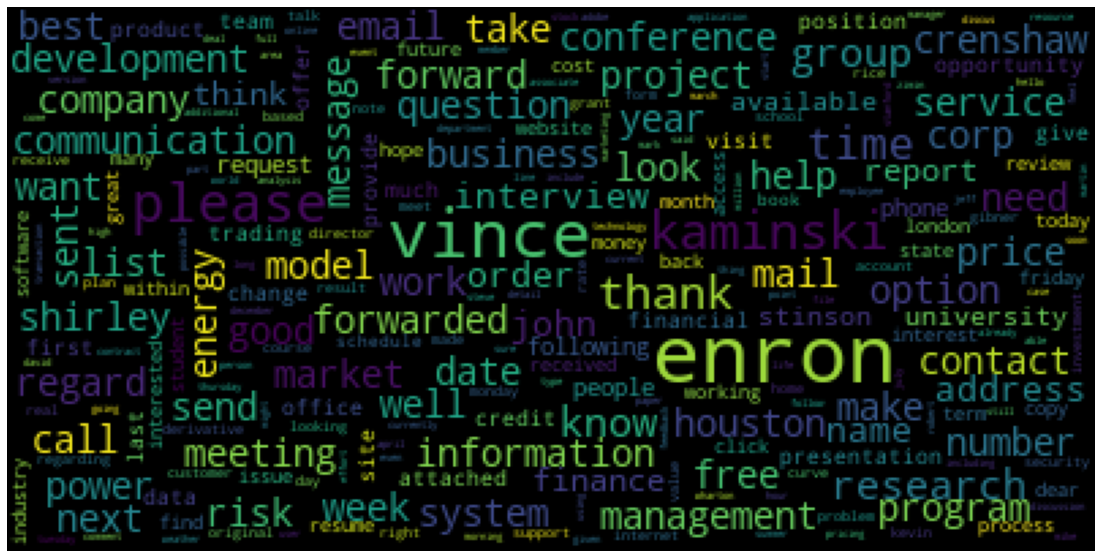

In [39]:
# Word CLoud 1 on the entire dataset

# text = " ".join(list(set([x for x in New_Data['X']])))
text = " ".join(New_Data['X'].str.cat().split(" "))
# print(type(text))
# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=30, max_words=1000, collocations=False).generate(text)

# Display the generated image:
plt.figure(figsize= [20,10])
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("Visuals/wordcloud_overall.jpeg" , bbox_inches='tight')
plt.show()

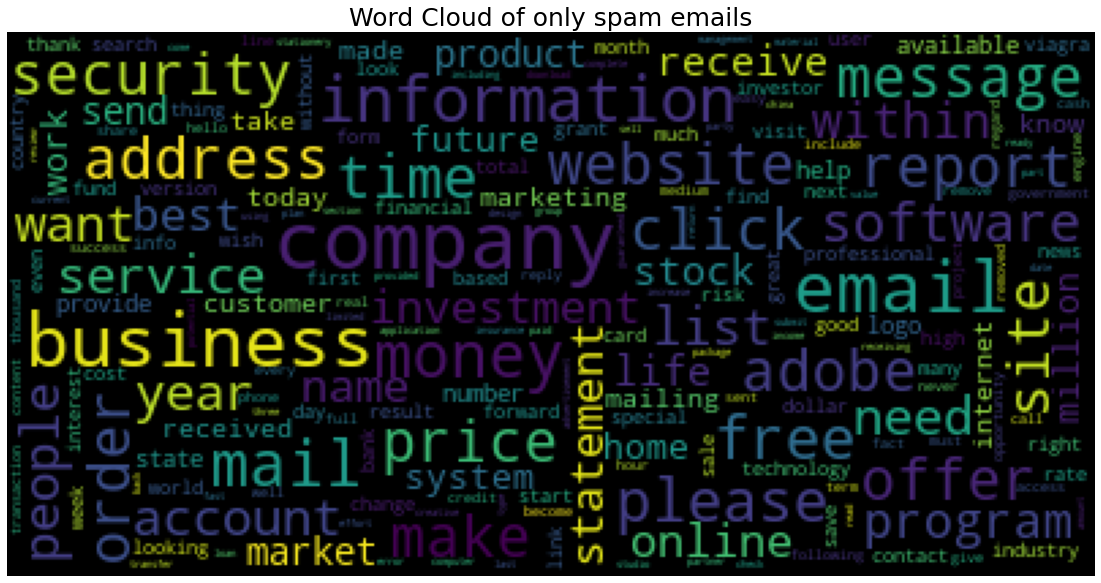

In [40]:
Only_Spam = New_Data.loc[New_Data["spam"] != 0]
# text = " ".join(list(set([x for x in Only_Spam['X']])))
text = " ".join(Only_Spam['X'].str.cat().split(" "))
# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=30, max_words=1000, collocations=False).generate(text)

# Display the generated image:
plt.figure(figsize= [20,10])
plt.title("Word Cloud of only spam emails",fontdict={"fontsize" : 25})
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("Visuals/wordcloud_spam.jpeg" , bbox_inches='tight')
plt.show()




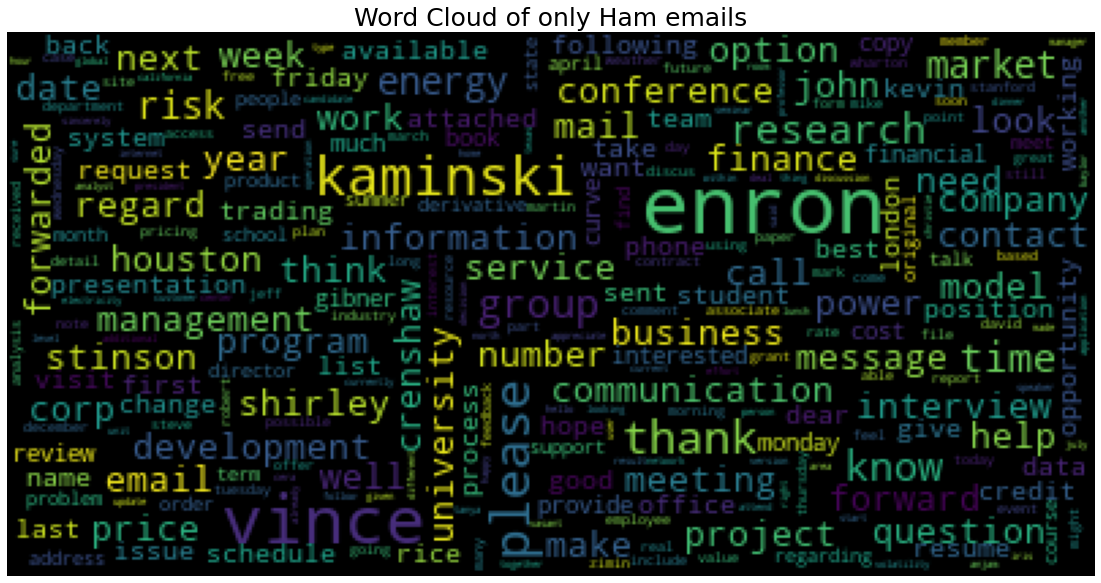

In [41]:
Only_Ham =  New_Data.loc[New_Data["spam"] != 1]
# text = " ".join(list([x for x in Only_Ham['X']]))
text = " ".join(Only_Ham['X'].str.cat().split(" "))
# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=30, max_words=1000,collocations=False).generate(text)

# Display the generated image:
plt.figure(figsize= [20,10])
plt.title("Word Cloud of only Ham emails", fontdict={"fontsize" : 25})
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("Visuals/wordcloud_ham.jpeg" , bbox_inches='tight')
plt.show()
# list_text = [x for x in Only_Ham['X']]
# print(type(list_text))
# print(list_text[:100])

# Word Frequency Distributions

Total number of all Words : 665686
Total number of all Distinct words : 31363
<FreqDist with 31363 samples and 665686 outcomes>


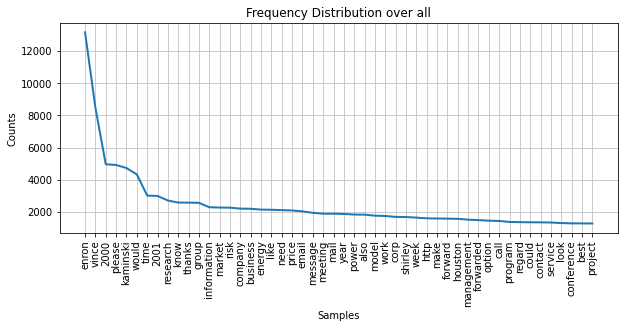

In [26]:
def Get_Flattened_list(data, column='Lemmatized', num=10):
    X_list = data[column].to_list()
    X_flattened = list(flatten(X_list))

    Total_num_of_all_words = len(X_flattened)
    Total_num_all_distinct_words = len(set(X_flattened))
    c = Counter(X_flattened)
    if num == 0:
        Most_Common_Words = c.most_common()
    else:
        Most_Common_Words = c.most_common(num)
    
    return X_list, X_flattened, Total_num_of_all_words, Total_num_all_distinct_words, Most_Common_Words

X_list, X_flattened, Total_num_of_all_words, Total_num_all_distinct_words, Most_Common_Words_10 = Get_Flattened_list(data)

print(f"Total number of all Words : {Total_num_of_all_words}")
print(f"Total number of all Distinct words : {Total_num_all_distinct_words}")
#print(f"\nMost common words : {Most_Common_Words_10}")

freq_dist = nltk.FreqDist(X_flattened)
print(freq_dist)

plt.ion()
fig = plt.figure(num = "Overall", figsize = (10,4))
plt.gcf().subplots_adjust(bottom=0.15) # to avoid x-ticks cut-off
plt.title("Frequency Distribution over all")
freq_dist.plot(50,cumulative=False)
fig.savefig("Visuals/Overall_Frequency_Distribution.jpeg", bbox_inches = "tight")
plt.ion()

Total number of all Words in Spam Distribution: 138786
Total number of all Distinct words in Spam Distribution: 15393
<FreqDist with 15393 samples and 138786 outcomes>


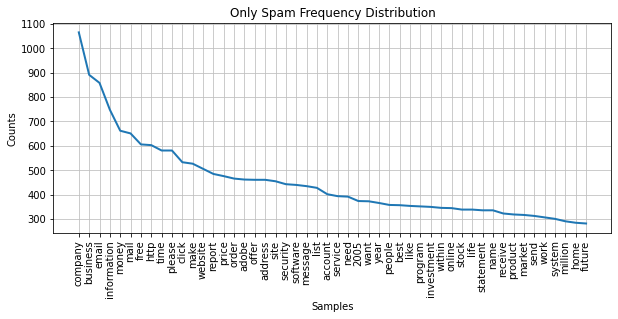

Total number of all Words in Ham Distribution: 526917
Total number of all Distinct words in Ham Distribution: 22381
<FreqDist with 22381 samples and 526917 outcomes>


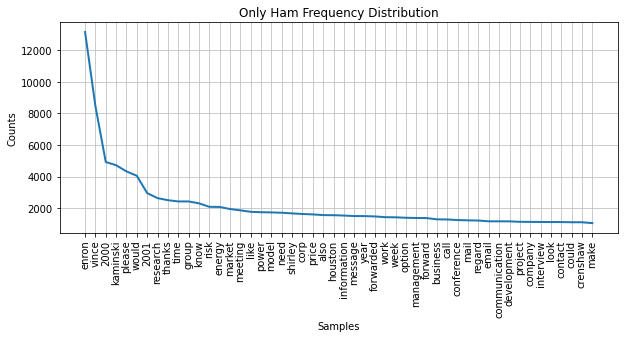

In [27]:
Only_Spam_FD = data.filter(['Lemmatized','spam'], axis=1)
Only_Spam_FD = Only_Spam_FD.loc[Only_Spam_FD["spam"] != 0]
Only_Ham_FD  = data.filter(['Lemmatized','spam'], axis=1)
Only_Ham_FD  = Only_Ham_FD.loc[Only_Ham_FD["spam"] != 1]

X_list, X_flattened_S, Total_num_of_all_words, Total_num_all_distinct_words, Most_Common_Words_10 = Get_Flattened_list(Only_Spam_FD)

print(f"Total number of all Words in Spam Distribution: {Total_num_of_all_words}")
print(f"Total number of all Distinct words in Spam Distribution: {Total_num_all_distinct_words}")
#print(f"\nMost common words : {Most_Common_Words_10}")

freq_dist_spam = nltk.FreqDist(X_flattened_S)
print(freq_dist_spam)

plt.ion()
fig = plt.figure(num = "Spam", figsize = (10,4))
plt.gcf().subplots_adjust(bottom=0.15) # to avoid x-ticks cut-off
plt.title("Only Spam Frequency Distribution")
freq_dist_spam.plot(50,cumulative=False)
fig.savefig("Visuals/Spam_Overall_Frequency_Distribution.jpeg", bbox_inches = "tight")
plt.ion()


X_list, X_flattened_H, Total_num_of_all_words, Total_num_all_distinct_words, Most_Common_Words_10 = Get_Flattened_list(Only_Ham_FD)

print(f"Total number of all Words in Ham Distribution: {Total_num_of_all_words}")
print(f"Total number of all Distinct words in Ham Distribution: {Total_num_all_distinct_words}")
#print(f"\nMost common words : {Most_Common_Words_10}")

freq_dist_Ham = nltk.FreqDist(X_flattened_H)
print(freq_dist_Ham)


plt.ion()
fig = plt.figure(num = "Ham" , figsize = (10,4))
plt.gcf().subplots_adjust(bottom=0.15) # to avoid x-ticks cut-off
plt.title("Only Ham Frequency Distribution")
freq_dist_Ham.plot(50,cumulative=False)
fig.savefig("Visuals/Ham_Overall_Frequency_Distribution.jpeg", bbox_inches = "tight")
plt.ion()

# Most and Least Common word Frequency Distribution , Further Visualisation

In [28]:
X_list, X_flattened_S, Total_num_of_all_words, Total_num_all_distinct_words, Most_Common_Words = Get_Flattened_list(data, num=0)

def counter(data, word):
    if word in data:
        return True

x =0
y =0
x_axis = {}
y_axis = {}


for i in range(30):
    y += 100
    #print(x,y)
    x_axis_l = []
    y_axis_l = []
    for word in Most_Common_Words[x:y]:
        #print(word)
        x_axis_l.append(word[0])
        count_documents = data["Lemmatized"].apply(counter,word=word[0]).count()
        y_axis_l.append(count_documents)
   
    x_axis[i] = x_axis_l
    y_axis[i] = y_axis_l
    if(i == 0):
        x += 101
    else: 
        x += 100
        
# Graph Loop

for i,j in zip(x_axis,y_axis):
    
    #fig, ax = plt.subplots()  # Create a figure containing a single axes.
    # ax.set_xticks(np.arange(0, 100, 5)) #step 5 digits
    fig = plt.figure(figsize=(18,7))
    line = sns.lineplot(x=x_axis[i], y=y_axis[j])
    #ax.plot(x_axis[i],y_axis[j])  # Plot some data on the axes.
    plt.xticks(rotation=90)
    plt.xlabel("Words")
    plt.ylabel("Count of Word Occurences")
    plt.legend(["Number of Documents Containing the Word"],framealpha=1, frameon=True)
    plt.grid(True)
    plt.savefig(f"EDA/MOST_Word_Counts_{i}.jpeg")
    plt.close(fig)

In [29]:
Least_common_words = Most_Common_Words.copy()
Least_common_words.reverse()
# print(Least_common_words)


x =0
y =0
x_axis = {}
y_axis = {}


for i in range(30):
    y += 100
    #print(x,y)
    x_axis_l = []
    y_axis_l = []
    for word in Least_common_words[x:y]:
        #print(word)
        x_axis_l.append(word[0])
        count_documents = data["Lemmatized"].apply(counter,word=word[0]).count()
        y_axis_l.append(count_documents)
   
    x_axis[i] = x_axis_l
    y_axis[i] = y_axis_l
    if(i == 0):
        x += 101
    else: 
        x += 100
        
# Graph Loop

for i,j in zip(x_axis,y_axis):
    
    #fig, ax = plt.subplots()  # Create a figure containing a single axes.
    # ax.set_xticks(np.arange(0, 100, 5)) #step 5 digits
    fig = plt.figure(figsize=(18,7))
    line = sns.lineplot(x=x_axis[i], y=y_axis[j])
    #ax.plot(x_axis[i],y_axis[j])  # Plot some data on the axes.
    plt.xticks(rotation=90)
    plt.xlabel("Words")
    plt.ylabel("Count of Word Occurences")
    plt.legend(["Number of Documents Containing the Word"],framealpha=1, frameon=True)
    plt.grid(True)
    plt.savefig(f"EDA/LEAST_Word_Counts_{i}.jpeg")
    plt.close(fig)

# Feature Extraction | Feature Engineering | Model generation | Model evaluation

### *TF-IDF : Term Frequency - Inverse Document Frequency*

### *The term frequency is the number of times a term occurs in a document. Inverse document frequency is an inverse function of the number of documents in which that a given word occurs.*

### *The product of these two terms gives tf-idf weight for a word in the corpus. The higher the frequency of occurrence of a word, lower is it's weight and vice-versa. This gives more weightage to rare terms in the corpus and penalizes more commonly occuring terms.*

### *Other widely used vectorizer is Count vectorizer which only considers the frequency of occurrence of a word across the corpus.*

In [30]:
#Test Train Split of Data

New_Data['spam'] = [1 if x == 1.0 else 0 for x in New_Data['spam']]

print(f"shape of the dataset : {New_Data.shape}, Number of rows and columns : {New_Data.shape[0]} , {New_Data.shape[1]}\n")
# Splitting the data - 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(New_Data["X"] , New_Data["spam"], test_size = 0.2, random_state = 99)
print(f"Training split input: {X_train.shape}")
print(f"Testing split input : {X_test.shape}")
print(f"Training split class: {y_train.shape}")
print(f"Testing split class : {y_test.shape}")

New_Data.head()

shape of the dataset : (5495, 2), Number of rows and columns : 5495 , 2

Training split input: (4396,)
Testing split input : (1099,)
Training split class: (4396,)
Testing split class : (1099,)


,X,spam
0,naturally irresistible corporate identity real...,1
1,stock trading gunslinger fanny merrill muzo co...,1
2,unbelievable home made easy wanting show homeo...,1
3,color printing special request additional info...,1
4,money software software compatibility great gr...,1


In [31]:
#Feature Extraction
"""
To extract features from the dataset we have used:
 -> Term Frequency Inverse Document Frequency Vectorizer
 
 -> This is a typical approach for converting text into a meaningful numerical
    representation, which is then used to fit a machine learning algorithm for prediction.
    
 -> The Tfidf Vectorizer learns the vocabulary, and inverses document frequency weights,
    also we can encode new documents using the same vectorizer.
    
 -> As input we pass text and in output of vectorizer each word have its own unique integer
    index in the output vector.
"""
tfidf = TfidfVectorizer()
X_train_vect = tfidf.fit_transform(X_train)
X_test_vect = tfidf.transform(X_test)

# Get feature names in the vector
#tfidf.get_feature_names()

X_train_vect.toarray()
print(f"Training data shape : {X_train_vect.shape}")
X_test_vect.toarray()
print(f"Testomg data shape : {X_test_vect.shape}")

Training data shape : (4396, 28165)
Testomg data shape : (1099, 28165)


# *Model Comparison*

In [32]:
models = {
    "Random Forest": {"model":RandomForestClassifier(), "perf":0, "y_pred" : 0},
    "Gradient Boosting": {"model":GradientBoostingClassifier(), "perf":0, "y_pred" : 0},
    "XGBoost": {"model":XGBClassifier(eval_metric='mlogloss'), "perf":0, "y_pred" : 0},
    "MultinomialNB": {"model":MultinomialNB(), "perf":0, "y_pred" : 0},
    "Logistic Regr.": {"model":LogisticRegression(), "perf":0, "y_pred" : 0},
    "KNN": {"model":KNeighborsClassifier(), "perf":0, "y_pred" : 0},
    "Decision Tree": {"model":DecisionTreeClassifier(), "perf":0, "y_pred" : 0},
    "SVM (Linear)": {"model":LinearSVC(), "perf":0, "y_pred" : 0},
    "SVM (RBF)": {"model":SVC(), "perf":0, "y_pred" : 0}
}

for name, model in models.items():
    start = perf_counter()
    model['model'].fit(X_train_vect, y_train)
    duration = perf_counter() - start
    duration = round(duration,2)
    model["perf"] = duration
    print(f"{name:20} trained in {duration} sec")

Random Forest        trained in 7.06 sec
Gradient Boosting    trained in 24.77 sec
XGBoost              trained in 18.89 sec
MultinomialNB        trained in 0.02 sec
Logistic Regr.       trained in 2.16 sec
KNN                  trained in 0.03 sec
Decision Tree        trained in 2.92 sec
SVM (Linear)         trained in 0.1 sec
SVM (RBF)            trained in 15.33 sec


In [33]:
models_acc = []
for name, model in models.items():
    models_acc.append([name, model["model"].score(X_test_vect, y_test),model["perf"]])

In [34]:
df_acc = pd.DataFrame(models_acc)
df_acc.columns = ['Model', 'Accuracy w/o scaling', 'Training time (sec)']
df_acc.sort_values(by = 'Accuracy w/o scaling', ascending = False, inplace=True)
df_acc.reset_index(drop = True, inplace=True)
df_acc

,Model,Accuracy w/o scaling,Training time (sec)
0,XGBoost,0.989991,18.89
1,SVM (Linear),0.987261,0.10
2,SVM (RBF),0.987261,15.33
3,Logistic Regr.,0.980892,2.16
4,Random Forest,0.971793,7.06
5,Gradient Boosting,0.968153,24.77
6,Decision Tree,0.962693,2.92
7,KNN,0.959964,0.03
8,MultinomialNB,0.889900,0.02


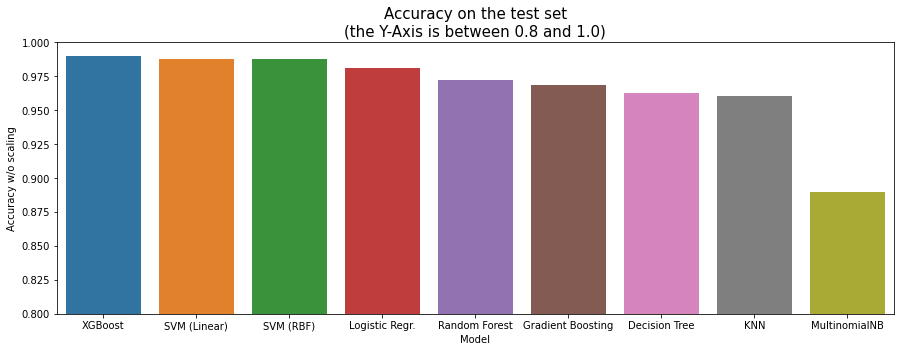

In [35]:
# Bar plot for accuracy
plt.figure(figsize = (15,5))
sns.barplot(x = 'Model', y = 'Accuracy w/o scaling', data = df_acc)
plt.title('Accuracy on the test set\n(the Y-Axis is between 0.8 and 1.0)', fontsize = 15)
plt.ylim(0.8,1)
plt.show()

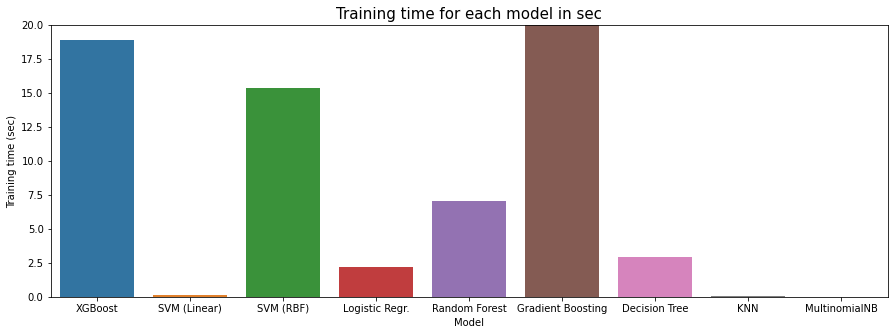

In [36]:
# Train time
plt.figure(figsize = (15,5))
sns.barplot(x = 'Model', y = 'Training time (sec)', data = df_acc)
plt.title('Training time for each model in sec', fontsize = 15)
plt.ylim(0,20)
plt.show()

# Hyper-parameter search : alpha(learning rate)

## *Model : Multinomial Naive Bayes*
## *Model : KNN*
## *Model : Random forest*

## *The bottom 3 classifiers in terms of accuracy

In [37]:
"""
MultinomialNB()
"""
# Find the best hyperparameter with GridSearchCV
# Exhaustive search over specified parameter values for an estimator.

parameters = {"alpha": [0.2,1,2,5,10], "fit_prior": [True, False]}

grid = GridSearchCV(MultinomialNB(), param_grid=parameters)
grid.fit(X_train_vect,y_train)

# Create a DataFrame with the best Hyperparameters
pd.DataFrame(grid.cv_results_)[['params','mean_test_score']]\
                               .sort_values(by="mean_test_score", ascending=False)

,params,mean_test_score
1,"{'alpha': 0.2, 'fit_prior': False}",0.987033
0,"{'alpha': 0.2, 'fit_prior': True}",0.978163
3,"{'alpha': 1, 'fit_prior': False}",0.949272
5,"{'alpha': 2, 'fit_prior': False}",0.916970
2,"{'alpha': 1, 'fit_prior': True}",0.890356
7,"{'alpha': 5, 'fit_prior': False}",0.887399
9,"{'alpha': 10, 'fit_prior': False}",0.870109
4,"{'alpha': 2, 'fit_prior': True}",0.839854
6,"{'alpha': 5, 'fit_prior': True}",0.804823
8,"{'alpha': 10, 'fit_prior': True}",0.775250


In [38]:
# Display the best hyperparameters
grid.best_params_

{'alpha': 0.2, 'fit_prior': False}

In [39]:
alpha, fit_prior = grid.best_params_['alpha'], grid.best_params_['fit_prior']
NB = MultinomialNB(alpha = alpha)

NB.fit(X_train_vect,y_train)
y_pred = NB.predict(X_test_vect)

printmd(f'## Accuracy: {round(accuracy_score(y_test,y_pred),3)*100}%\n')

## Accuracy: 97.7%


In [40]:
categories = ['Ham', 'Spam']
NB_report = classification_report(y_test,y_pred,target_names=categories)
print(NB_report)

              precision    recall  f1-score   support

         Ham       0.97      1.00      0.98       813
        Spam       1.00      0.91      0.95       286

    accuracy                           0.98      1099
   macro avg       0.99      0.96      0.97      1099
weighted avg       0.98      0.98      0.98      1099



In [41]:
def get_confusion_matrix_heatmap(y_test,y_pred,fName):
    # Confusion Matrix
    # sklearn builtin function to calculate confusion matrix values using true labels and predictions
    CF = confusion_matrix(y_test,y_pred.round())
    # list of labels that will be displayed on the image boxes
    labels = ['True Neg','False Pos','False Neg','True Pos']
    # list of all possible label values
    categories = ['Spam', 'Ham']
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    # count total values present in each cell of the matrix
    group_counts = ["{0:0.0f}".format(value) for value in CF.flatten()]
    # count percentage of total values present in each cell of the matrix
    group_percentages = ["{0:.2%}".format(value) for value in CF.flatten()/np.sum(CF)]
    # group the labels to plot in graph
    labels = [f"{v1}\n{v2}\n{v3}"for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    # reshape true label values according to the requirement
    labels = np.asarray(labels).reshape(2,2)
    # declare graph using heatmap function
    heatmap=sns.heatmap(CF, annot=labels, fmt='', cmap='Blues')
    # plot confusion matrix
    fig = heatmap.get_figure()
    # save confusion matrix as image in results folder
    fig.savefig('heatmaps/'+fName)
    # display confusion matrix as numeric values
    print(CF)

[[813   0]
 [ 25 261]]


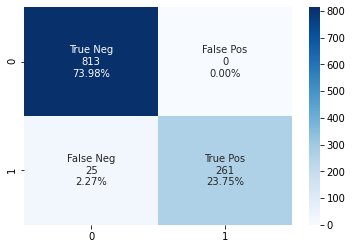

In [42]:
get_confusion_matrix_heatmap(y_test, y_pred, "Naive_Bayes.jpeg")

AUC: 0.9562937062937062


0.9562937062937062

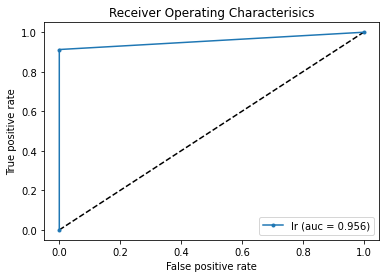

In [43]:
# AUC
"""
The Receiver Operator Characteristic curve is an evaluation metric used for binary classification
tasks.
1. It provides the ratio between TPR and FPR.
2. Higher the value of auc the best is the model's performance.
3. Usually the best scenario is when curve is moving upward on the left most and at the peak it
   turns toward right most side
4. It's a probability curve that displays the TPR against the FPR at different threshold values.
5. The Area Under the Curve (AUC) is a description of the curve that measures a classifier's ability
   to discriminate between classes.
6. Usually when the dataset is highly imbalanced AUC evaluation metric provides actual
   performance of the model
"""
def ROC_AUC(y_test, y_pred, fname):
    # evluate true positive rate and false positive rate using sklearn builtin function
    lr_fpr, lr_tpr, _ = roc_curve(y_test, y_pred)
    # find area under curve score
    lr_auc = auc(lr_fpr, lr_tpr)

    # display auc score
    print("AUC:", lr_auc)
    # plot linear line with no learning
    plt.plot([0, 1], [0, 1], 'k--')
    # plot tpr and fpr ratio
    plt.plot(lr_fpr, lr_tpr, marker='.', label='lr (auc = %0.3f)' % lr_auc)
    # assign labels
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Receiver Operating Characterisics')
    plt.legend(loc='lower right')
    plt.savefig(f"Visuals/{fname}")
    return lr_auc

ROC_AUC(y_test, y_pred, "AUC_NB.jpeg")


# Confusion matrix heatmap , AUC of all other classifiers

## Accuracy: 97.2%


[[813   0]
 [ 31 255]]
Time taken 0.7489810740080429 secs


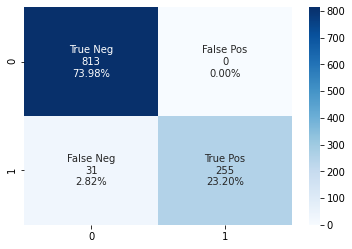

In [44]:
"""
RandomForestClassifier()
"""
start = perf_counter()
y_pred = models["Random Forest"]["model"].predict(X_test_vect)
printmd(f'## Accuracy: {round(accuracy_score(y_test,y_pred),3)*100}%\n')

#confusion matrix
get_confusion_matrix_heatmap(y_test, y_pred, "Random_Forest.jpeg")
end = perf_counter() - start

print(f"Time taken {end} secs")

AUC: 0.9458041958041958


0.9458041958041958

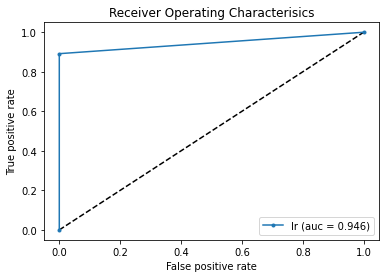

In [45]:
#AUC
ROC_AUC(y_test, y_pred, "AUC_Random_Forest.jpeg")

## Accuracy: 99.0%


[[805   8]
 [  3 283]]


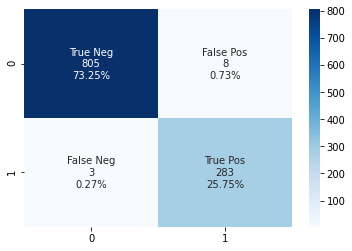

In [46]:
"""
XGBClassifier()
"""
y_pred = models["XGBoost"]["model"].predict(X_test_vect)
printmd(f'## Accuracy: {round(accuracy_score(y_test,y_pred),3)*100}%\n')

#confusion matrix
get_confusion_matrix_heatmap(y_test, y_pred, "XGBoost.jpeg")

AUC: 0.9898351955547529


0.9898351955547529

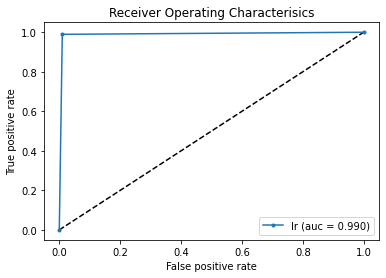

In [47]:
#AUC
ROC_AUC(y_test, y_pred, "AUC_XGBoost.jpeg")

## Accuracy: 98.1%


[[812   1]
 [ 20 266]]


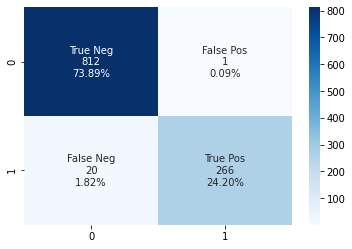

In [48]:
"""
LogisticRegression()
"""
y_pred = models["Logistic Regr."]["model"].predict(X_test_vect)
printmd(f'## Accuracy: {round(accuracy_score(y_test,y_pred),3)*100}%\n')

#confusion matrix
get_confusion_matrix_heatmap(y_test, y_pred, "Logistic_Regression.jpeg")

AUC: 0.9644199588849036


0.9644199588849036

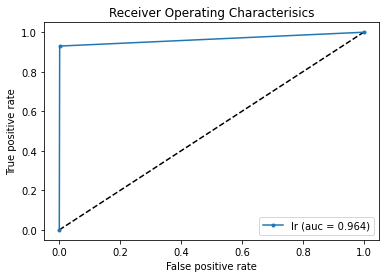

In [49]:
#AUC
ROC_AUC(y_test, y_pred, "AUC_Logistic_regression.jpeg")

## Accuracy: 96.3%


[[801  12]
 [ 29 257]]


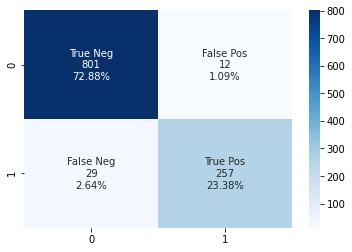

In [50]:
"""
DescisionTreeClassifier()
"""
y_pred = models["Decision Tree"]["model"].predict(X_test_vect)
printmd(f'## Accuracy: {round(accuracy_score(y_test,y_pred),3)*100}%\n')

#confusion matrix
get_confusion_matrix_heatmap(y_test, y_pred, "Descision_Tree.jpeg")

AUC: 0.9419206254999614


0.9419206254999614

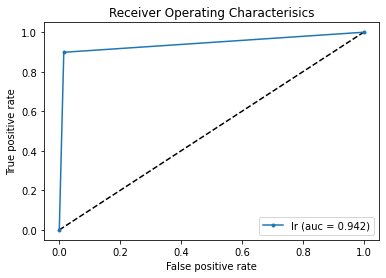

In [51]:
#AUC
ROC_AUC(y_test, y_pred, "AUC_Descision_Tree.jpeg")

## Accuracy: 98.7%


[[809   4]
 [ 10 276]]


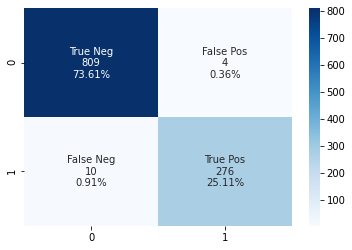

In [52]:
"""
LinearSVC()
"""
y_pred = models["SVM (Linear)"]["model"].predict(X_test_vect)
printmd(f'## Accuracy: {round(accuracy_score(y_test,y_pred),3)*100}%\n')

#confusion matrix
get_confusion_matrix_heatmap(y_test, y_pred, "Linear_SVC.jpeg")

AUC: 0.9800574579172364


0.9800574579172364

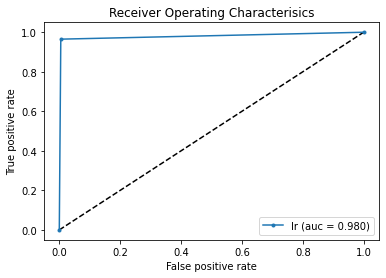

In [53]:
#AUC
ROC_AUC(y_test, y_pred, "AUC_SVM_Linear.jpeg")

## Accuracy: 98.7%


[[810   3]
 [ 11 275]]


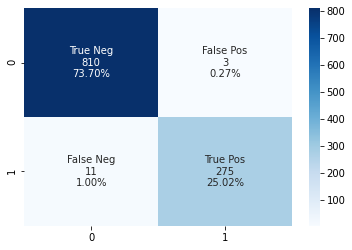

In [54]:
"""
SVC()
"""
y_pred = models["SVM (RBF)"]["model"].predict(X_test_vect)
printmd(f'## Accuracy: {round(accuracy_score(y_test,y_pred),3)*100}%\n')

#confusion matrix
get_confusion_matrix_heatmap(y_test, y_pred, "SVC.jpeg")

AUC: 0.9789242123190464


0.9789242123190464

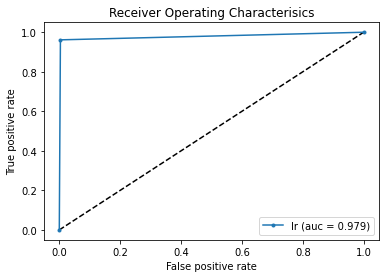

In [55]:
#AUC
ROC_AUC(y_test, y_pred, "AUC_SVC.jpeg")

# Metrics Comparison : 

## *Precision*
#### The precision is the ratio ``tp / (tp + fp)`` where ``tp`` is the number of true positives and ``fp`` the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

## *Recall* 
#### The recall is the ratio ``tp / (tp + fn)`` where ``tp`` is the number of true positives and ``fn`` the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

## *f1 score*  
#### The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:
    F1 = 2 * (precision * recall) / (precision + recall)
    
## *Accuracy*
#### In multilabel classification, this function computes subset accuracy: the set of labels predicted for a sample must *exactly* match the corresponding set of labels in y_true.

In [56]:
from sklearn.metrics import f1_score

def get_Metrics(y_test, y_pred, average="macro"):
    
    lr_fpr, lr_tpr, _ = roc_curve(y_test, y_pred)
    # find area under curve score
    lr_auc = auc(lr_fpr, lr_tpr)
    precision = precision_score(y_test, y_pred, average = average)
    recall = recall_score(y_test, y_pred, average = average)
    f1_score_ = f1_score(y_test, y_pred, average = average)
    accuracy = accuracy_score(y_test, y_pred)
    #print(f"precision : {precision} recall : {recall} f1_score : {f1_score_} accuracy : {accuracy}")
    return precision, recall, f1_score_, accuracy, lr_auc


for name, model in models.items():
    
    model["y_pred"] = model['model'].predict(X_test_vect)
    duration = model["perf"]
    print(f"{name:20} trained in {duration} sec")

# print(y_test.shape)
models_metrics = []
for name, model in models.items():
    #print(model["y_pred"].shape)
    y_pred = model["y_pred"]
    precision, recall, f1_score_, accuracy, lr_auc = get_Metrics(y_test, y_pred)
    #print(f"precision : {precision} recall : {recall} f1_score : {f1_score_} accuracy : {accuracy}")
    models_metrics.append([name, precision, recall, f1_score_, accuracy, lr_auc, model["perf"]])
    
df_metrics = pd.DataFrame(models_metrics)
df_metrics.columns = ['Model', 'Precision', 'Recall', 'f1 score', 'Accuracy', 'ROC-AUC', 'Training time (sec)']
df_metrics.sort_values(by = 'Accuracy', ascending = False, inplace=True)
df_metrics.reset_index(drop = True, inplace=True)
df_metrics.to_csv('Visuals/Metrics_Comparison.csv')
df_metrics


Random Forest        trained in 7.06 sec
Gradient Boosting    trained in 24.77 sec
XGBoost              trained in 18.89 sec
MultinomialNB        trained in 0.02 sec
Logistic Regr.       trained in 2.16 sec
KNN                  trained in 0.03 sec
Decision Tree        trained in 2.92 sec
SVM (Linear)         trained in 0.1 sec
SVM (RBF)            trained in 15.33 sec


,Model,Precision,Recall,f1 score,Accuracy,ROC-AUC,Training time (sec)
0,XGBoost,0.984398,0.989835,0.987075,0.989991,0.989835,18.89
1,SVM (Linear),0.986752,0.980057,0.983343,0.987261,0.980057,0.10
2,SVM (RBF),0.987905,0.978924,0.983305,0.987261,0.978924,15.33
3,Logistic Regr.,0.986108,0.964420,0.974630,0.980892,0.964420,2.16
4,Random Forest,0.981635,0.945804,0.961995,0.971793,0.945804,7.06
5,Gradient Boosting,0.972522,0.944477,0.957408,0.968153,0.944477,24.77
6,Decision Tree,0.960225,0.941921,0.950586,0.962693,0.941921,2.92
7,KNN,0.968443,0.927610,0.945718,0.959964,0.927610,0.03
8,MultinomialNB,0.935225,0.788462,0.831223,0.889900,0.788462,0.02


In [75]:
# Download the augmented dataset 
# New_Data.to_csv('Augmented_emails.csv')

In [69]:
models_for_saving = {
    "Random Forest": {"model":RandomForestClassifier()},
    "Gradient Boosting": {"model":GradientBoostingClassifier()},
    "XGBoost": {"model":XGBClassifier(eval_metric='mlogloss')},
    "MultinomialNB": {"model":NB},
    "Logistic Regr.": {"model":LogisticRegression()},
    "KNN": {"model":KNeighborsClassifier()},
    "Decision Tree": {"model":DecisionTreeClassifier()},
    "SVM (Linear)": {"model":LinearSVC()},
    "SVM (RBF)": {"model":SVC()}
}

filenames = ["Random_forest.pkl" , "Gradient_Boosting.pkl" , "XGBoost.pkl" , "MultinomialNB.pkl" , "Logistic_regression.pkl" ,
            "KNN.pkl" , "Decision_tree.pkl" , "SVM_linear.pkl" , "SVM_RBF.pkl"]
index = 0
for name, model in models_for_saving.items():
    print(name) 
    with open(f"comparison/classifiers/{filenames[index]}", "wb") as open_file:
        pickle.dump(model['model'], open_file)
    index += 1

Random Forest
Gradient Boosting
XGBoost
MultinomialNB
Logistic Regr.
KNN
Decision Tree
SVM (Linear)
SVM (RBF)


In [76]:
dataset_processed = {
    "X_train" : X_train,
    "X_test"  : X_test ,
    "y_train" : y_train,
    "y_test"  : y_test ,
    "tf-idf"  : tfidf  
}

with open(f"comparison/classifiers/train_test_tf_idf.pkl", "wb") as open_file:
    pickle.dump(dataset_processed, open_file)

In [77]:
# Get feature names in the vector
tfidf.get_feature_names()

['0000',
 '000000',
 '00000000',
 '0000000000',
 '000000000003991',
 '000000000003997',
 '000000000005411',
 '000000000005412',
 '000000000005413',
 '000000000005820',
 '000000000006238',
 '000000000006452',
 '000000000007494',
 '000000000007876',
 '000000000010552',
 '000000000011185',
 '000000000012734',
 '000000000012735',
 '000000000012736',
 '000000000012738',
 '000000000012741',
 '000000000012987',
 '000000000013085',
 '000000000013287',
 '000000000015384',
 '000000000023619',
 '000000000024099',
 '000000000025307',
 '000000000025312',
 '000010220',
 '0000102317',
 '0000102374',
 '0000102789',
 '0000104281',
 '0000104282',
 '0000104486',
 '0000104631',
 '0000104730',
 '0000104776',
 '0000104778',
 '0000107043',
 '0000108729',
 '000066',
 '0001',
 '000166',
 '0002',
 '000202',
 '0003',
 '0004',
 '0005',
 '0006',
 '0009249480',
 '0009249481',
 '0009249504',
 '0009249505',
 '0009249506',
 '0011',
 '0015',
 '00193',
 '00225',
 '00235424',
 '0029',
 '0031',
 '003399',
 '00343938',
 '0